In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

Loading all LR frames from: inference/LR/calendar
Loaded 37 LR frames
Saved cropped LR frame: inference_results/LR\lr_cropped_000.png
Saved cropped LR frame: inference_results/LR\lr_cropped_001.png
Saved cropped LR frame: inference_results/LR\lr_cropped_002.png
Saved cropped LR frame: inference_results/LR\lr_cropped_003.png
Saved cropped LR frame: inference_results/LR\lr_cropped_004.png
Saved cropped LR frame: inference_results/LR\lr_cropped_005.png
Saved cropped LR frame: inference_results/LR\lr_cropped_006.png
Saved cropped LR frame: inference_results/LR\lr_cropped_007.png
Saved cropped LR frame: inference_results/LR\lr_cropped_008.png
Saved cropped LR frame: inference_results/LR\lr_cropped_009.png
Saved cropped LR frame: inference_results/LR\lr_cropped_010.png
Saved cropped LR frame: inference_results/LR\lr_cropped_011.png
Saved cropped LR frame: inference_results/LR\lr_cropped_012.png
Saved cropped LR frame: inference_results/LR\lr_cropped_013.png
Saved cropped LR frame: inference_

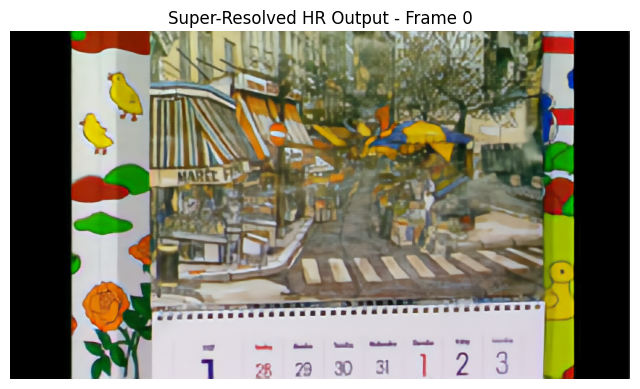

Processed window 2/35: saved as inference_results/HR\hr_frame_001.png
Processed window 3/35: saved as inference_results/HR\hr_frame_002.png
Processed window 4/35: saved as inference_results/HR\hr_frame_003.png
Processed window 5/35: saved as inference_results/HR\hr_frame_004.png
Processed window 6/35: saved as inference_results/HR\hr_frame_005.png


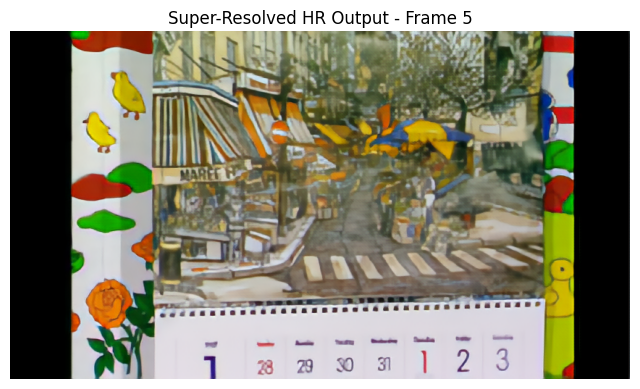

Processed window 7/35: saved as inference_results/HR\hr_frame_006.png
Processed window 8/35: saved as inference_results/HR\hr_frame_007.png
Processed window 9/35: saved as inference_results/HR\hr_frame_008.png
Processed window 10/35: saved as inference_results/HR\hr_frame_009.png
Processed window 11/35: saved as inference_results/HR\hr_frame_010.png


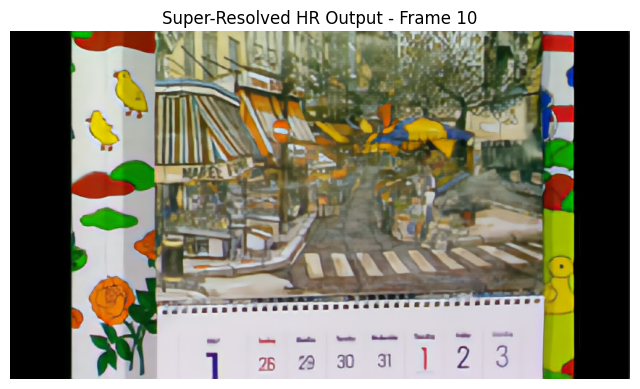

Processed window 12/35: saved as inference_results/HR\hr_frame_011.png
Processed window 13/35: saved as inference_results/HR\hr_frame_012.png
Processed window 14/35: saved as inference_results/HR\hr_frame_013.png
Processed window 15/35: saved as inference_results/HR\hr_frame_014.png
Processed window 16/35: saved as inference_results/HR\hr_frame_015.png


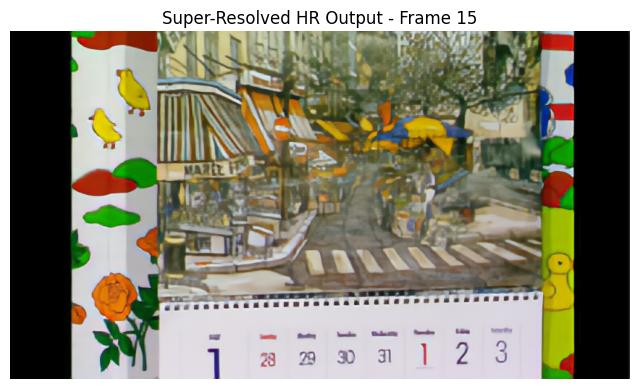

Processed window 17/35: saved as inference_results/HR\hr_frame_016.png
Processed window 18/35: saved as inference_results/HR\hr_frame_017.png
Processed window 19/35: saved as inference_results/HR\hr_frame_018.png
Processed window 20/35: saved as inference_results/HR\hr_frame_019.png
Processed window 21/35: saved as inference_results/HR\hr_frame_020.png


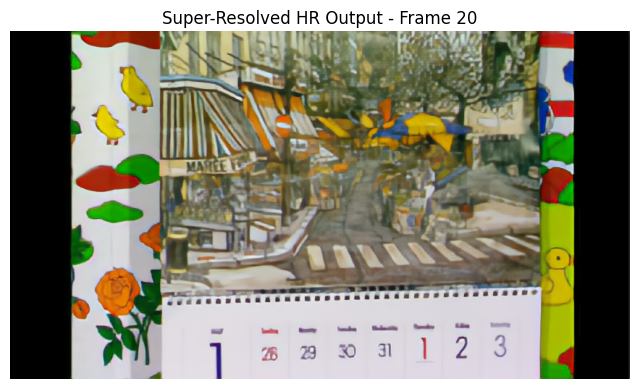

Processed window 22/35: saved as inference_results/HR\hr_frame_021.png
Processed window 23/35: saved as inference_results/HR\hr_frame_022.png
Processed window 24/35: saved as inference_results/HR\hr_frame_023.png
Processed window 25/35: saved as inference_results/HR\hr_frame_024.png
Processed window 26/35: saved as inference_results/HR\hr_frame_025.png


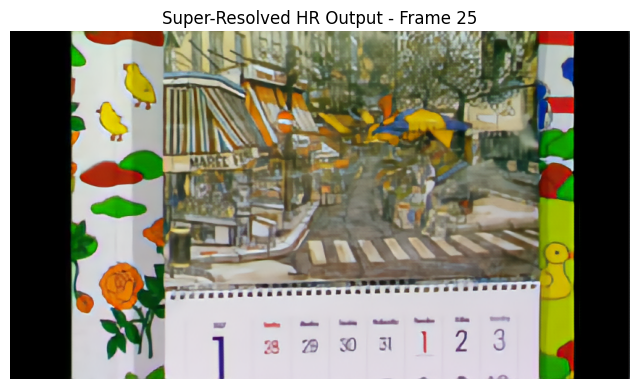

Processed window 27/35: saved as inference_results/HR\hr_frame_026.png
Processed window 28/35: saved as inference_results/HR\hr_frame_027.png
Processed window 29/35: saved as inference_results/HR\hr_frame_028.png
Processed window 30/35: saved as inference_results/HR\hr_frame_029.png
Processed window 31/35: saved as inference_results/HR\hr_frame_030.png


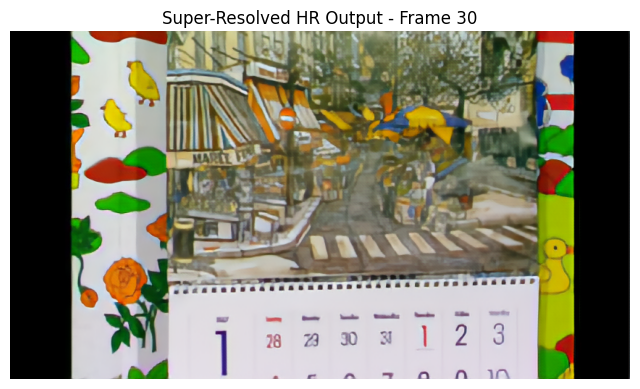

Processed window 32/35: saved as inference_results/HR\hr_frame_031.png
Processed window 33/35: saved as inference_results/HR\hr_frame_032.png
Processed window 34/35: saved as inference_results/HR\hr_frame_033.png
Processed window 35/35: saved as inference_results/HR\hr_frame_034.png
Processing complete! 35 HR frames saved to inference_results/HR
37 cropped LR frames saved to inference_results/LR


In [3]:


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Model Definitions
# ----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x + residual

# Base SR Model (first stage)
class SRModel(nn.Module):
    def __init__(self, in_channels=9, out_channels=3, features=64, num_res_blocks=5, upscale_factor=4):
        super(SRModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, features, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(features) for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(features, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.res_blocks(x)
        x = self.conv2(x)
        x = self.pixel_shuffle(x)
        return x

# Refinement Network (second stage)
class RefinementNet(nn.Module):
    def __init__(self, channels=3, features=64, num_res_blocks=3):
        super(RefinementNet, self).__init__()
        self.conv_in = nn.Conv2d(channels, features, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(features) for _ in range(num_res_blocks)])
        self.conv_out = nn.Conv2d(features, channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        out = F.relu(self.conv_in(x))
        out = self.res_blocks(out)
        out = self.conv_out(out)
        # Residual connection: refine rather than re-predict entirely.
        return x + out

# Composite Two-Stage SR Model
class TwoStageSRModel(nn.Module):
    def __init__(self, base_model, refinement_model):
        super(TwoStageSRModel, self).__init__()
        self.base_model = base_model
        self.refinement_model = refinement_model
        
    def forward(self, x):
        base_output = self.base_model(x)
        refined_output = self.refinement_model(base_output)
        return refined_output

# ----------------------------
# Preprocessing and Inference Functions
# ----------------------------
def center_crop(img, target_size):
    """Center crops the image to the target size (width, height)."""
    width, height = img.size
    target_w, target_h = target_size
    left = (width - target_w) // 2
    top = (height - target_h) // 2
    return img.crop((left, top, left + target_w, top + target_h))

# Transformation: convert image to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def load_all_lr_frames(lr_dir, target_size=(214, 120)):
    """
    Loads all LR frames (PNG) from the specified directory and center-crops them.
    Returns both the cropped PIL images and transformed tensors.
    """
    lr_files = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir) if f.endswith(".png")])
    if len(lr_files) < 3:
        raise ValueError("At least 3 LR frames are required in the directory.")
    
    lr_pil_imgs = []
    lr_tensors = []
    
    for file in lr_files:
        if not os.path.exists(file):
            raise FileNotFoundError(f"LR frame not found: {file}")
        img = Image.open(file).convert("RGB")
        cropped_img = center_crop(img, target_size)
        
        # Save the PIL image for later use
        lr_pil_imgs.append(cropped_img)
        
        # Transform to tensor
        img_tensor = transform(cropped_img)
        lr_tensors.append(img_tensor)
    
    return lr_pil_imgs, lr_tensors

def create_sliding_window_tensor(lr_tensors, window_size=3, index=0):
    """
    Creates a tensor for the sliding window starting at index.
    Each window contains window_size consecutive frames.
    """
    # Ensure we don't go beyond the list bounds
    if index + window_size > len(lr_tensors):
        raise ValueError(f"Index {index} with window size {window_size} exceeds available frames.")
    
    # Get frames in the current window
    window_tensors = lr_tensors[index:index + window_size]
    
    # Concatenate along channel dimension: window_size frames × 3 channels
    window_stack = torch.cat(window_tensors, dim=0)
    return window_stack.unsqueeze(0)  # Add batch dimension

def infer_hr(lr_tensor, model):
    """
    Runs the model on the LR tensor to produce an HR image.
    The output is denormalized to [0, 1] and converted to a PIL image.
    """
    lr_tensor = lr_tensor.to(device)
    with torch.no_grad():
        hr_output = model(lr_tensor)
    hr_output = (hr_output + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    hr_output = hr_output.clamp(0, 1)
    return transforms.ToPILImage()(hr_output.squeeze(0).cpu())

def load_model(model_path):
    """
    Instantiates the two-stage SR model and loads the weights from the checkpoint.
    Expects the checkpoint to contain a 'state_dict' key.
    """
    base_model = SRModel(in_channels=9, out_channels=3, features=64, num_res_blocks=5, upscale_factor=4)
    refinement_net = RefinementNet(channels=3, features=64, num_res_blocks=3)
    model = TwoStageSRModel(base_model, refinement_net)
    model.to(device)
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['state_dict']  # Only load model parameters
    model.load_state_dict(state_dict)
    model.eval()
    return model

# ----------------------------
# Set your paths here
# ----------------------------
# Replace these with the appropriate paths on your system:
lr_dir = "inference/LR/calendar"        # Directory with LR PNG images
model_path = "models/2 stage/l1 + vgg/best.pth"  # Path to your saved checkpoint
output_dir = "inference_results/HR"         # Output directory for HR images
crop_output_dir = "inference_results/LR"   # Output directory for cropped LR images
target_size = (214, 120)               # Target size for center cropping (width, height)

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(crop_output_dir, exist_ok=True)

# ----------------------------
# Run Inference with Sliding Window
# ----------------------------
print("Loading all LR frames from:", lr_dir)
lr_pil_imgs, lr_tensors = load_all_lr_frames(lr_dir, target_size)
print(f"Loaded {len(lr_tensors)} LR frames")

# Save all cropped LR frames
for i, img in enumerate(lr_pil_imgs):
    output_path = os.path.join(crop_output_dir, f"lr_cropped_{i:03d}.png")
    img.save(output_path)
    print(f"Saved cropped LR frame: {output_path}")

print("Loading model from:", model_path)
model = load_model(model_path)

# Process frames with sliding window
total_output_frames = len(lr_tensors) - 2  # For window size 3
print(f"Processing {total_output_frames} windows...")

for i in range(total_output_frames):
    # Create window tensor from 3 consecutive frames
    window_tensor = create_sliding_window_tensor(lr_tensors, window_size=3, index=i)
    
    # Generate HR frame
    hr_img = infer_hr(window_tensor, model)
    
    # Save HR output
    output_path = os.path.join(output_dir, f"hr_frame_{i:03d}.png")
    hr_img.save(output_path)
    print(f"Processed window {i+1}/{total_output_frames}: saved as {output_path}")

    # Optional: display one frame every 5 frames
    if i % 5 == 0:
        plt.figure(figsize=(8, 8))
        plt.imshow(hr_img)
        plt.axis("off")
        plt.title(f"Super-Resolved HR Output - Frame {i}")
        plt.show()

print(f"Processing complete! {total_output_frames} HR frames saved to {output_dir}")
print(f"{len(lr_pil_imgs)} cropped LR frames saved to {crop_output_dir}")

# Optional: code to compile frames into a video using OpenCV or ffmpeg
# Uncomment and customize as needed:
# import cv2
# def create_video_from_frames(frame_dir, output_file, fps=30):
#     frames = sorted([os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".png")])
#     if not frames:
#         raise ValueError("No frames found in directory")
#     
#     # Read the first frame to get dimensions
#     first_frame = cv2.imread(frames[0])
#     height, width, _ = first_frame.shape
#     
#     # Create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
#     video = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
#     
#     # Add frames to video
#     for frame_path in frames:
#         frame = cv2.imread(frame_path)
#         video.write(frame)
#     
#     # Release the video writer
#     video.release()
#     print(f"Video saved as {output_file}")
# 
# # Create video from HR frames
# create_video_from_frames(output_dir, "hr_output_video.mp4", fps=30)